In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# import os
# os.chdir('/content/drive/MyDrive/GSS16')

In [3]:
import pandas as pd
import numpy as np
import pyreadr

import matplotlib.pyplot as plt
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import norm, gamma, poisson

import statsmodels.api as sm
import statsmodels.formula.api as smf

from statsmodels.tools.eval_measures import rmse, mse

from zmq.constants import NULL
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [4]:
df = pyreadr.read_r('./data/gss16.rda')
gss16 = df['gss16']

# 1. Tiền xử lý dữ liệu và thống kê mô tả

Loại bỏ các row có trường nhãn (thời gian dùng email bị null)

In [5]:
dat = gss16[(gss16['emailmin'].notna())&(gss16['emailhr'].notna())]

Tạo cột tổng thời gian dùng email từ 2 cột về số giờ, số phút dùng email. Sau đó xóa 2 cột giờ/phút dùng email ban đầu

In [6]:
dat["emailmintotal"] = dat["emailmin"] + dat["emailhr"]*60
dat.drop(["emailhr", "emailmin"], axis=1, inplace= True)

C:\Users\dungl\AppData\Local\Temp\ipykernel_10100\3823905499.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat["emailmintotal"] = dat["emailmin"] + dat["emailhr"]*60
C:\Users\dungl\AppData\Local\Temp\ipykernel_10100\3823905499.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.drop(["emailhr", "emailmin"], axis=1, inplace= True)


In [7]:
dat.shape

(1649, 8)

In [8]:
dat.describe()

,educ,emailmintotal
count,1648.000000,1649.000000
mean,14.037621,416.842329
std,2.722956,680.148486
min,2.000000,0.000000
25%,12.000000,50.000000
50%,14.000000,120.000000
75%,16.000000,480.000000
max,20.000000,6000.000000


Như vậy, dữ liệu giờ chỉ còn 2 cột dữ liệu dạng số. Các cột còn lại là loại categorical. Ta kiểm tra số giá trị null tại mỗi cột và thống kê số lượng các giá trị khác null.

In [9]:
for col in dat.columns:
    if col in ["harass5", "polviews", "advfront", "snapchat", "instagrm", "wrkstat"]:
        print("field: ", col)
        print('- number of NaN value: {0:2d} ({1:.2f}%)'.format(dat[col].isna().sum(), dat[col].isna().sum()/1649))
        print('- values:')
        print(dat[col].value_counts())
        print('\n')
    elif col == "educ":
        print("field: ", col)
        print('- number of NaN value:', dat[col].isna().sum())
        print('\n')

field:  harass5
- number of NaN value: 1218 (0.74%)
- values:
harass5
No                                                         350
Yes                                                         62
Does not apply (i do not have a job/superior/co-worker)     19
Name: count, dtype: int64


field:  educ
- number of NaN value: 1


field:  polviews
- number of NaN value: 55 (0.03%)
- values:
polviews
Moderate                595
Conservative            239
Slghtly conservative    228
Liberal                 212
Slightly liberal        180
Extremely liberal        81
Extrmly conservative     59
Name: count, dtype: int64


field:  advfront
- number of NaN value: 433 (0.26%)
- values:
advfront
Agree                673
Strongly agree       367
Disagree             152
Dont know             13
Strongly disagree     11
Name: count, dtype: int64


field:  snapchat
- number of NaN value: 969 (0.59%)
- values:
snapchat
No     516
Yes    164
Name: count, dtype: int64


field:  instagrm
- number of NaN v

Như vậy, 1 số cột categorical có tỷ lệ null khá nhiều (harass5 có 3/4 giá trị null, advfront có 1/4 số dòng null, snapchat và instagrm có gần 60% số dòng null). Vì vậy, với các cột categorical, ta mã hóa các giá trị null thành 1 nhóm riêng.

Cột dữ liệu số có 1 mẫu educ bị null. Vì số lượng nhỏ nên ta loại bỏ mẫu này.

In [10]:
dat = dat[dat['educ'].notna()]

dat.fillna("Not give", inplace=True)

In [11]:
dat.replace("Does not apply (i do not have a job/superior/co-worker)", "Does not apply", inplace=True)

**1.a. Kiểm tra phân phối của biến phụ thuôc**

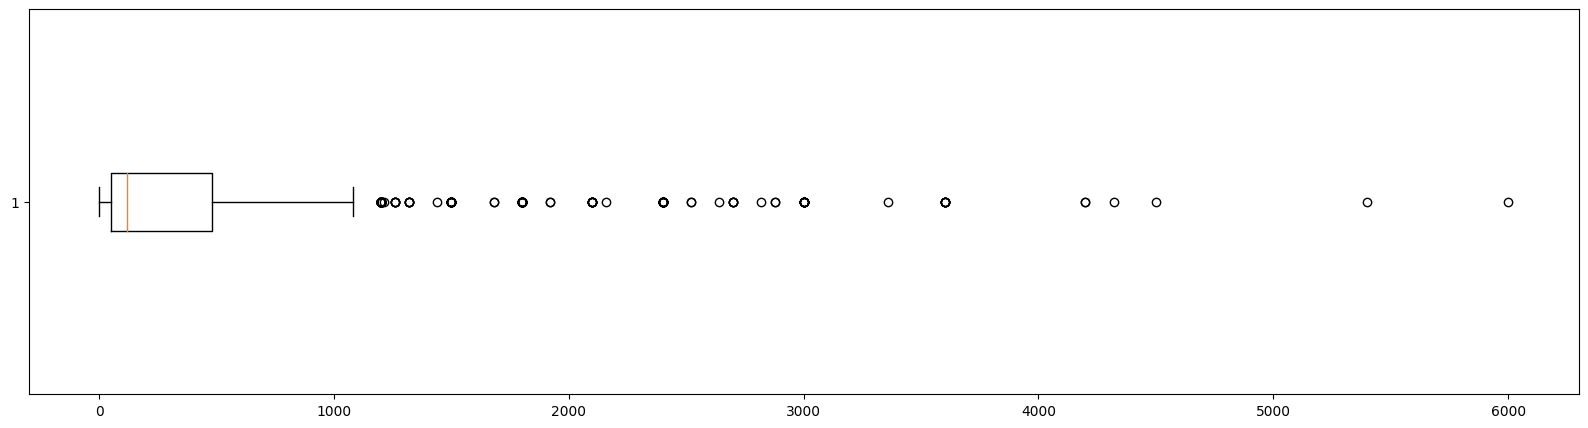

In [12]:
plt.figure(figsize=(20, 5))
plt.boxplot(dat['emailmintotal'], vert=False)
plt.show()

Có thể thấy dữ liệu emailmintotal rất phân tán, giá trị trong khoảng [0, 6000]. Dữ liệu tập trung nhiều ở vùng giá trị thấp, hình ảnh right skewed rõ nét.

Ta xem thêm biểu đồ histogram về phân phối của dữ liệu:

(0.0, 100.0)

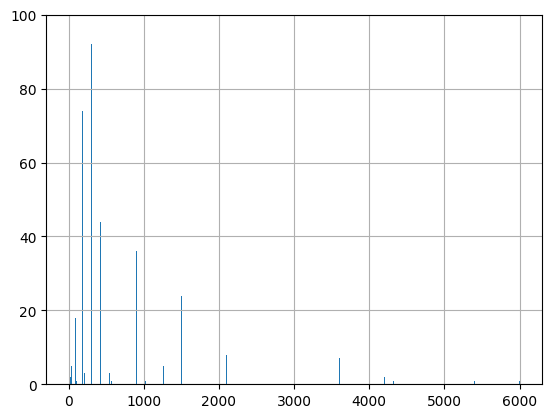

In [13]:
dat['emailmintotal'].hist(bins = 1300)
plt.ylim([0,100])

Có thể thấy, emailmintotal là biến liên tục không âm, gợi ý về phân phối Gamma (ta có thể cộng thêm 1 hằng số dương để đảm bảo giá trị luôn dương). Và với biểu đồ histogram phía trên cũng có hình ảnh phân phối Gamma.

Ta sẽ dùng biểu đồ QQplot để kiểm tra thêm việc này.

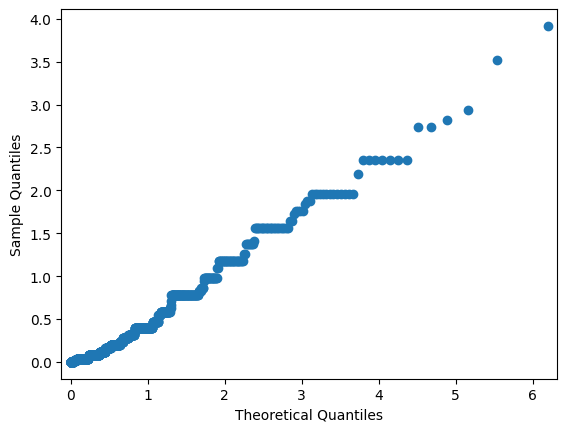

In [14]:
qqplot(dat["emailmintotal"],gamma,fit=True)
plt.show()

Như vậy, emailmintotal khá khớp với phân phối **Gamma**

Để đảm bảo điều kiện của phân phối Gamma (emailmintotal dương), ta cộng vào nó 1 hằng số dương.

In [15]:
dat['emailmintotal'] += 1

**1.b. Xem xét sự phụ thuộc của biến đầu ra so với các biến giải thích**

Xem xét emailmintotal đối với các cột categorical

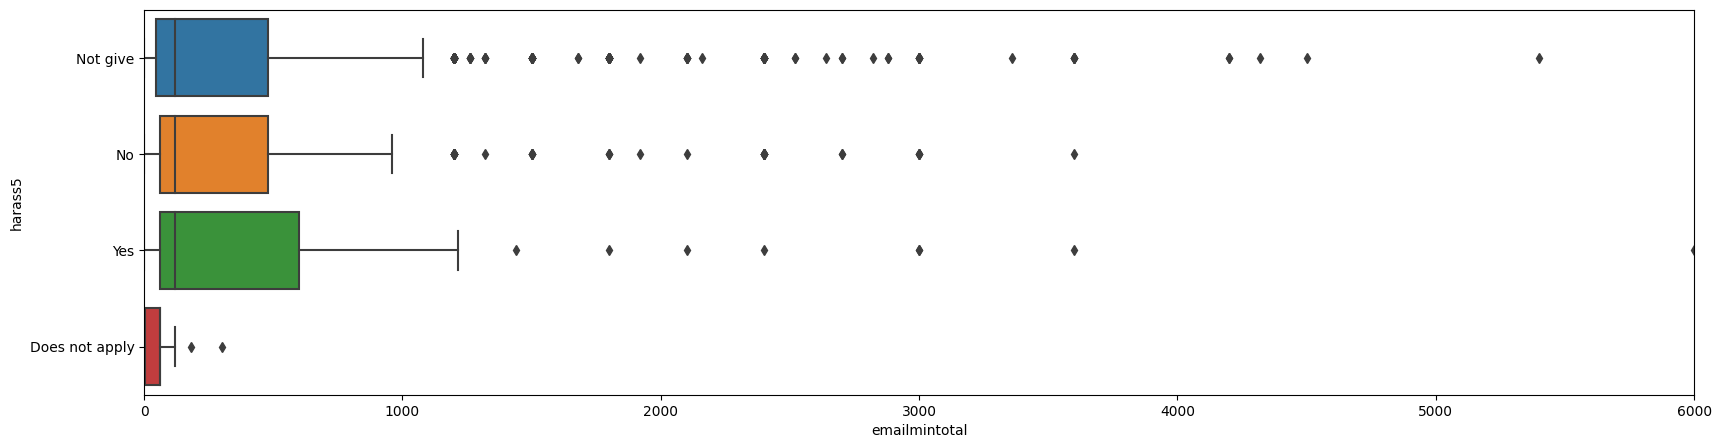

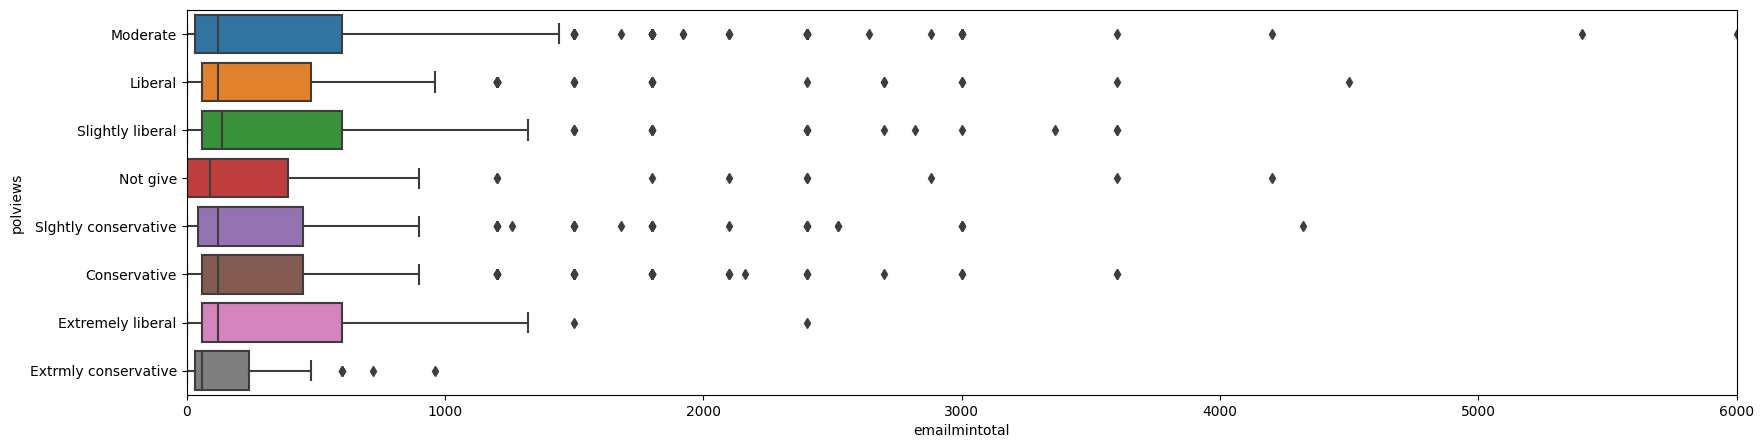

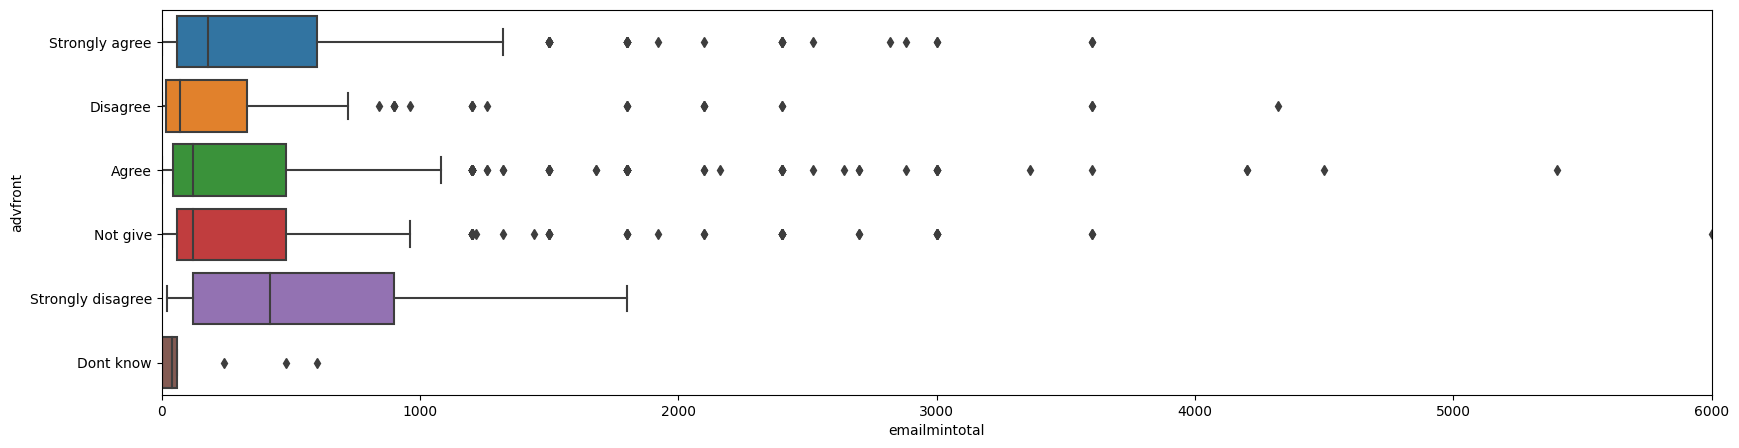

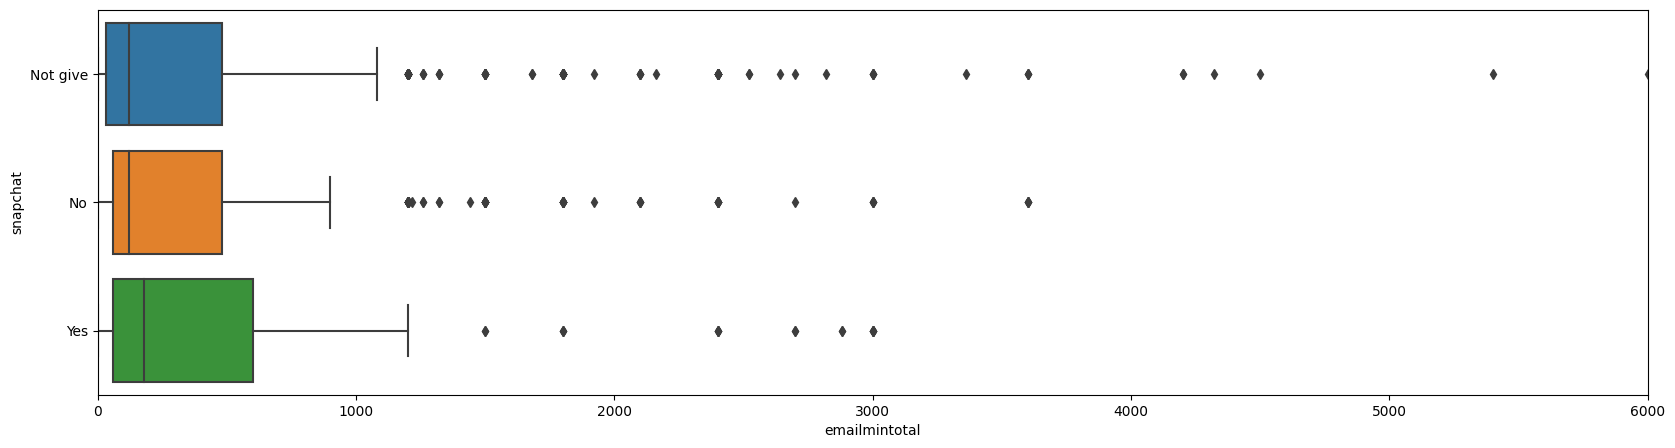

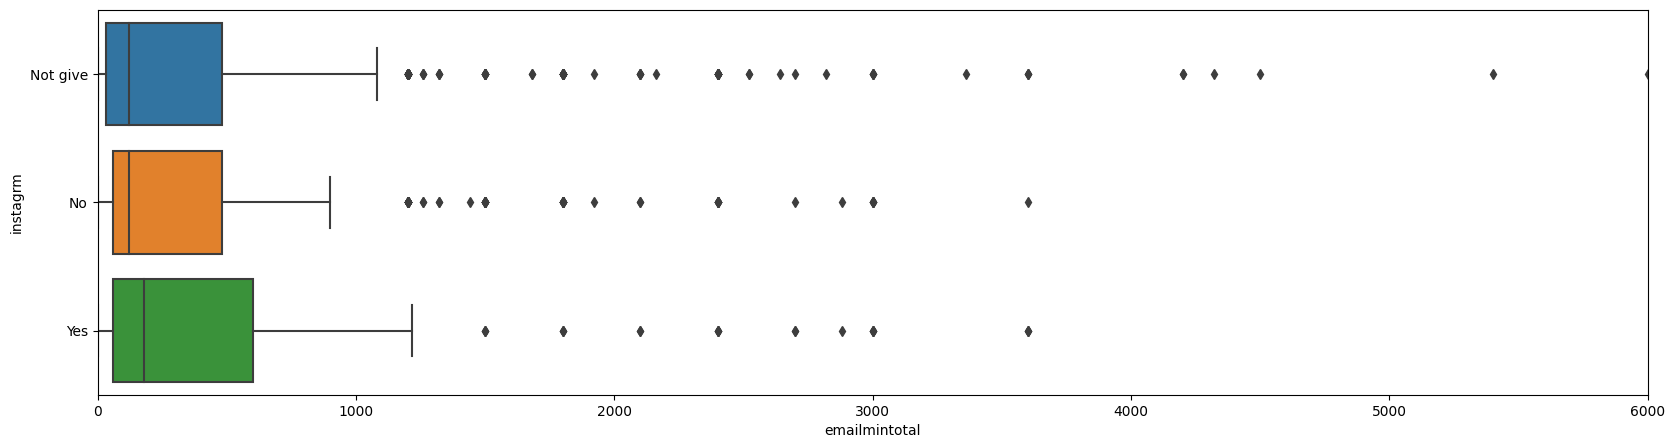

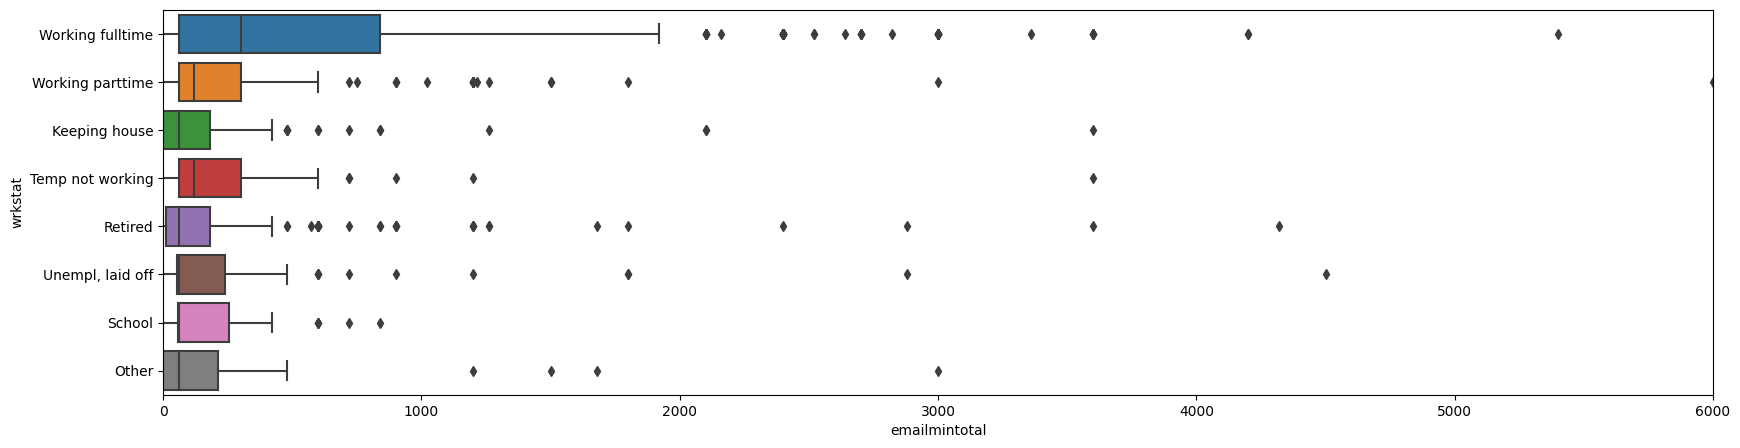

In [16]:
import seaborn as sns

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="harass5")
plt.xlim([0, 6000])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="polviews")
plt.xlim([0, 6000])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="advfront")
plt.xlim([0, 6000])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="snapchat")
plt.xlim([0, 6000])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="instagrm")
plt.xlim([0, 6000])
plt.show()

plt.figure(figsize=(20, 5))
sns.boxplot(data=dat, x="emailmintotal", y="wrkstat")
plt.xlim([0, 6000])
plt.show()

Nhận xét:
- **harass**: nhóm không đi làm ít dùng email hơn 3 nhóm còn lại.
- **polviews**: nhóm Extrmly conservative dùng email ít hơn các nhóm còn lại.
- **advfront**: nhóm Strong disagree dùng nhiều email hơn hẳn các nhóm còn lại, sau đó tới nhóm Strong agree. Nhóm Dont know là dùng email ít nhất.
- **snapchat, instagrm**:  Nhân tố Snapchat và nhân tố Instagram có phân bố như nhau trên cả 3 giá trị (Dont know, No, Yes). Trong đó nhóm Yes dùng email nhiều hơn 2 nhóm còn lại, nghĩa là người dùng mạng xã hội có xu hướng dùng email nhiều hơn.
- **wrkstat**: nhóm "working fulltime" dùng email nhiều hơn hẳn các nhóm còn lại. Các nhóm không đi làm (Keeping house, Retired, Unempl/laid off, School, Other) có mức dùng email ít nhất. Các nhóm làm bán thời gian (working parttime, temp not working) có mức dùng email ở giữa nhóm đi làm và nhóm không đi làm.

Bản thân trong mỗi nhóm, số lượng outlier vẫn khá nhiều (dữ liệu khá phân tán).

Xem xét sự phụ thuộc của emailmintotal đối với biến educ (biến dạng số duy nhất ở đây)

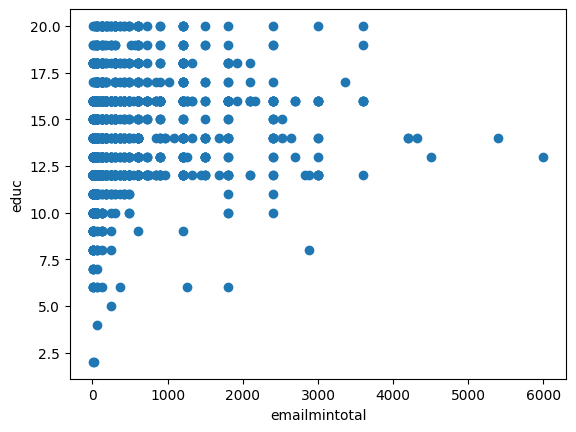

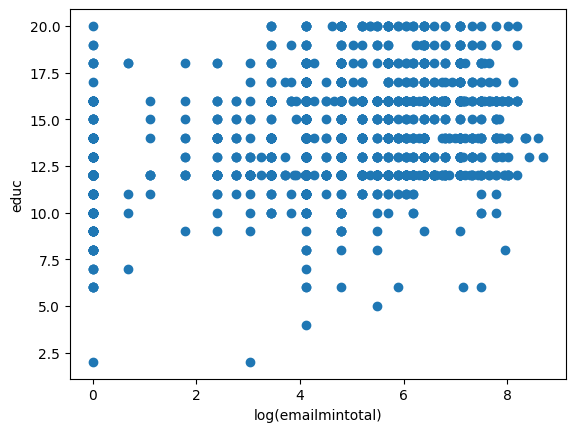

In [17]:
plt.scatter(dat["emailmintotal"], dat["educ"])
plt.xlabel("emailmintotal")
plt.ylabel("educ")
plt.show()

plt.scatter(np.log(dat["emailmintotal"]), dat["educ"])
plt.xlabel("log(emailmintotal)")
plt.ylabel("educ")
plt.show()


Biểu đồ scatter giữa educ và emailmintotal chưa thấy rõ được quan hệ tuyến tính giữa 2 biến này.

Ta chuyển scale cho emailmintotal bằng hàm log và kiểm tra lại. Ta thấy educ có quan hệ gần như tuyến tính với log(emailmintotal), mặc dù độ phân tán khá lớn. Điều này gợi ý ta dùng **link function là hàm log**.

Trong phần tiếp theo ta sẽ lựa chọn và xây dựng mô hình để dự đoán cho emailmintotal. **2 mô hình được lựa chọn thử nghiệm là GLM (Generalized Linear Model) và GAM (Generalized Additive Model).**

Trước tiên, ta tạm chia tập train/test theo tỷ lệ 80:20:

In [18]:
dat_train = dat.sample(frac = 0.8, random_state = 42)
dat_test = dat.drop(dat_train.index)

# 2. Mô hình GLM

**2.a. Lựa chọn thuộc tính**

Sau đó ta thử cho tất cả các cột vào fit mô hình GLM xem kết quả như thế nào:

In [19]:
formula_str = 'emailmintotal ~ harass5 + educ + polviews + advfront + snapchat + instagrm + wrkstat'
fitted_glm = smf.glm(formula=formula_str, data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()

print('AIC: ', fitted_glm.aic)
fitted_glm.summary()

AIC:  17654.265486952725


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          emailmintotal   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1291
Model Family:                   Gamma   Df Model:                           26
Link Function:                    Log   Scale:                          2.6356
Method:                          IRLS   Log-Likelihood:                -8800.1
Date:                Sun, 13 Aug 2023   Deviance:                       3394.2
Time:                        15:02:46   Pearson chi2:                 3.40e+03
No. Iterations:                    24   Pseudo R-squ. (CS):             0.1316
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            5.3082      1.290      4.115      0.000       2.780       7.837
harass5[T.No]                        0.7896      0.440      1.794      0.073      -0.073       1.652
harass5[T.Not give]                 -1.9238      1.234     -1.559      0.119      -4.342       0.495
harass5[T.Yes]                       1.2071      0.493      2.447      0.014       0.240       2.174
polviews[T.Extremely liberal]       -0.4150      0.244     -1.698      0.090      -0.894       0.064
polviews[T.Extrmly conservative]    -0.6418      0.269     -2.383      0.017      -1.170      -0.114
polviews[T.Liberal]                 -0.1751      0.175     -1.000      0.317      -0.518       0.168
polviews[T.Moderate]                 0.0129      0.141      0.092      0.927      -0.262       0.288
polviews[T.Not give]                 0.5666      0.272      2.084      0.037       0.034       1.099
polviews[T.Slghtly conservative]    -0.2808      0.167     -1.678      0.093      -0.609       0.047
polviews[T.Slightly liberal]        -0.0529      0.182     -0.291      0.771      -0.409       0.303
advfront[T.Disagree]                 0.4629      0.169      2.742      0.006       0.132       0.794
advfront[T.Dont know]               -0.4225      0.528     -0.801      0.423      -1.457       0.612
advfront[T.Not give]                -2.8305      1.162     -2.436      0.015      -5.108      -0.553
advfront[T.Strongly agree]           0.0832      0.118      0.703      0.482      -0.149       0.315
advfront[T.Strongly disagree]        0.4624      0.579      0.798      0.425      -0.673       1.598
snapchat[T.Not give]                -0.0283      0.058     -0.485      0.627      -0.142       0.086
snapchat[T.Yes]                      0.2202      0.192      1.147      0.251      -0.156       0.596
instagrm[T.Not give]                -0.0283      0.058     -0.485      0.627      -0.142       0.086
instagrm[T.Yes]                      0.0389      0.172      0.226      0.821      -0.299       0.376
wrkstat[T.Other]                     1.3332      0.406      3.282      0.001       0.537       2.129
wrkstat[T.Retired]                   0.2858      0.189      1.513      0.130      -0.085       0.656
wrkstat[T.School]                    0.2614      0.315      0.828      0.407      -0.357       0.880
wrkstat[T.Temp not working]          0.7596      0.339      2.240      0.025       0.095       1.424
wrkstat[T.Unempl, laid off]          0.9421      0.269      3.501      0.000       0.415       1.469
wrkstat[T.Working fulltime]          1.3070      0.169      7.753      0.000       0.977       1.637
wrkstat[T.Working parttime]          0.7950      0.203      3.911      0.000       0.397       1.193
educ                                 0.1184      0.01

Tuy nhiên, để xây dựng mô hình ta cần phải lựa chọn các feature để đưa vào sao cho tối ưu.

Ta sẽ làm theo phương án forward stepwise, nghĩa là thêm lần lượt từng feature vào mô hình, tính toán AIC cho tới khi AIC ngừng giảm thì dừng.

Ta biết rằng stepwise đôi khi không chính xác và phụ thuộc vào thứ tự các feature được thêm vào. Vì vậy ta sẽ thêm các feature theo thứ tự độ ảnh hưởng đến biến đầu ra giảm dần.

Trở lại với kết quả phần thống kê mô tả dữ liệu, biểu đồ boxplot về các biến so với thời gian dùng email. Ta thấy:


*   **wrkstat** có mức ảnh hưởng lớn nhất tới emailmintotal vì thời gian dùng email rất khác biệt giữa các giá trị wrkstat, đặc biệt là nhóm working fulltime. Ngoài ra, biến này dữ liệu khá đầy đủ (chỉ bị null 1 dòng ban đầu mà ta đã xóa lúc tiền xử lý). Thực tế thì email gắn chặt với công việc nên ta tạm thời tin tưởng vào nhận xét này.
*   **educ** được chọn là biến ảnh hưởng thứ 2 sau wrkstat. Lý do là biểu đồ scatter cũng cho thấy mức độ dùng email khác biệt nhiều giữa các giá trị educ. Cột educ này cũng đầy đủ dữ liệu như cột wrkstat. Trên thực tế việc dùng email phục vụ học tập cũng khá phổ biến, tuy nhiên 1 người đi học thì có thể dùng ít email hơn người đi làm nên cột educ này ta xếp độ ưu tiên sau cột wrkstat.
*   **polviews** được chọn là cột tiếp theo vì cột này cũng có sự khác biệt về mức dùng email giữa các polviews. Cột này thiếu 3% dữ liệu, thiếu nhiều hơn so với wrkstat và educ nhưng thiếu ít hơn so với các cột còn lại.
*   **advfront** được chọn tiếp theo vì cột này cũng có sự khác biệt và nó thiếu 26% dữ liệu, thiếu nhiều hơn so với polviews và thiếu ít hơn so với các cột còn lại.
*   **snapchat** và **instagrm** xếp tiếp sau vì chúng có mức dùng email không khác biệt nhiều giữa các nhóm trả lời Yes/No/NaN. 2 cột này đều thiếu gần 60% giá trị nên độ tin cậy cũng thấp.
*   **harass5** là cột cuối cùng vì cột này thiếu nhiều giá trị nhất (75% số dòng bị NaN).

Xem xét thêm sự tương tác giữa các biến:


*   **wrkstat và educ** có thể có quan hệ với nhau vì ta suy luận rằng số năm đi học rất ảnh hưởng tới tình trạng công việc. 2 biến đơn cũng có độ ảnh hưởng dẫn đầu nên ta cũng xếp biến tương tác wrkstat:educ có ảnh hưởng lớn nhất trong số các biến tương tác
*   **polviews và advfront** cũng có thể có quan hệ với nhau vì lập trường chính trị nói chung có ảnh hưởng tới quan điểm về các vấn đề xã hội cụ thể. 2 biến độc lập này cũng có thứ tự ưu tiên cao nên ta tạm xếp biến tương tác polviews:advfront đứng thứ 2 trong số các biến tương tác.
*   **wrkstat và harass5** có quan hệ với nhau vì tình trạng công việc ảnh hưởng tới việc có bị bắt nạt ở chỗ làm hay không (ví dụ không đi làm hoặc làm bán thời gian thì sẽ có ít khả năng bị bắt nạt ở chỗ làm so với đi làm full time).
*   **snapchat và instagrm** có quan hệ với nhau vì người thích dùng mạng xã hội sẽ có xu hướng dùng nhiều mạng xã hội cùng lúc. Biến tương tác snapchat:instagrm được xếp đứng cuối cùng vì độ ảnh hưởng của 2 biến độc lập đều được đánh giá thấp.


Vậy ta sẽ đưa thêm lần lượt từng feature theo thứ tự trên để fit mô hình và đánh giá AIC, BIC tương ứng.







c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood ve

Models:  ['emailmintotal ~ wrkstat', 'emailmintotal ~ wrkstat + educ', 'emailmintotal ~ wrkstat + educ + polviews', 'emailmintotal ~ wrkstat + educ + polviews + advfront', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm + harass5', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm + harass5 + wrkstat:educ', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm + harass5 + wrkstat:educ + polviews:advfront', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5', 'emailmintotal ~ wrkstat + educ + polviews + advfront + snapchat + instagrm + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5 + snapchat:instagrm']
AIC:  [17768.50459416527, 17758.816217531654, 17723.750402223774, 1

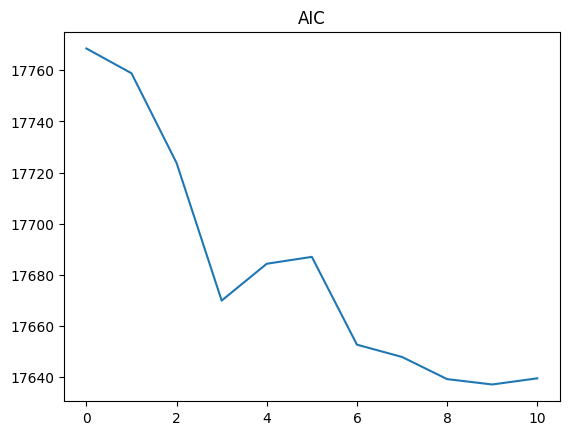

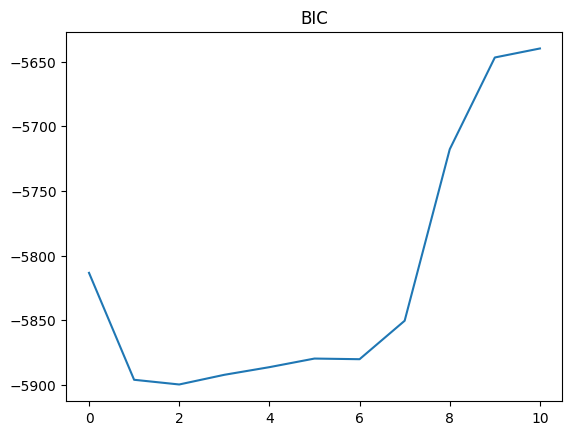

In [20]:
features = ["wrkstat", "educ", "polviews", "advfront", "snapchat", "instagrm", "harass5", "wrkstat:educ", "polviews:advfront", "wrkstat:harass5", "snapchat:instagrm"] #
formula = ['emailmintotal ~ ']
i=0
aic = []
bic = []

while (i < len(features)):
    if i==0:
        formula[0] += features[i]
    else:
        formula.append(formula[i-1] + ' + ' + features[i])

    # print(formula[i])

    fitted_glm = NULL
    fitted_glm = smf.glm(formula=formula[i], data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
    aic.append(fitted_glm.aic)
    bic.append(fitted_glm.bic)

    i += 1

print('Models: ', formula)
print('AIC: ', aic)
print('BIC: ', bic)

plt.plot(range(11), aic)
plt.title("AIC")
plt.show()

plt.plot(range(11), bic)
plt.title("BIC")
plt.show()

Nhìn vào danh sách AIC tương ứng với các mô hình có thể thấy nhận xét của ta về thứ tự độ quan trọng của các biến khá chính xác:


*   AIC giảm dần từ mô hình 0 đến mô hình 4
*   Từ mô hình 5 AIC tăng dần
*   Tuy nhiên đến mô hình 6 thì AIC giảm đột ngột trở lại và giảm cho đến mô hình cuối

Như vậy, có thể ta đã đánh giá thấp độ quan trọng của cột harass5. Ta sẽ xếp lại thứ thự các feature và thử lại việc tính AIC như trên xem sao.

c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(
c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood ve

Models:  ['emailmintotal ~ wrkstat', 'emailmintotal ~ wrkstat + educ', 'emailmintotal ~ wrkstat + educ + polviews', 'emailmintotal ~ wrkstat + educ + polviews + advfront', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ + polviews:advfront', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5 + snapchat:instagrm', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5 + snapchat:instagrm + instagrm', 'emailmintotal ~ wrkstat + educ + polviews + advfront + harass5 + wrkstat:educ + polviews:advfront + wrkstat:harass5 + snapchat:instagrm + instagrm + snapchat']
AIC:  [1776

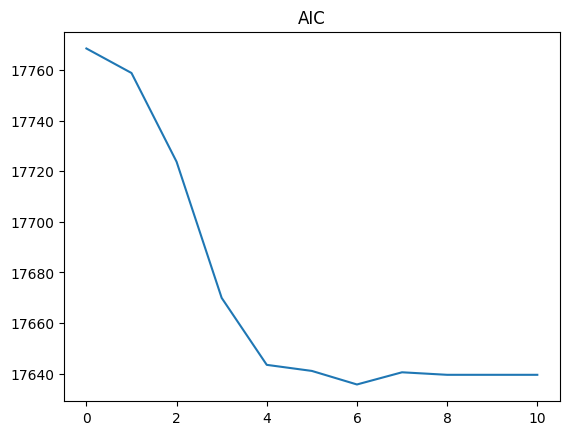

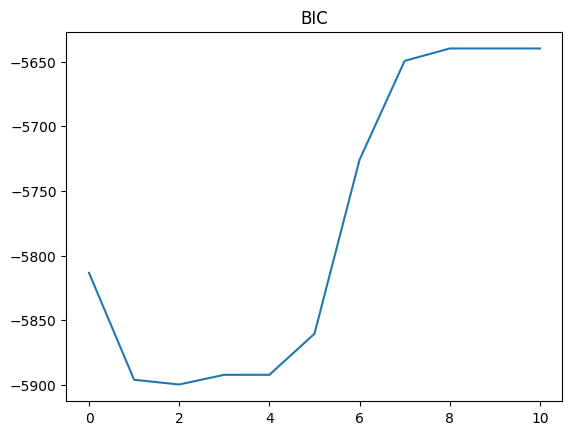

In [21]:
features = ["wrkstat", "educ", "polviews", "advfront", "harass5", "wrkstat:educ", "polviews:advfront", "wrkstat:harass5", "snapchat:instagrm", "instagrm", "snapchat" ]
formula = ['emailmintotal ~ ']
i=0
aic = []
bic = []


while (i < len(features)):
    if i==0:
        formula[0] += features[i]
    else:
        formula.append(formula[i-1] + ' + ' + features[i])

    # print(formula[i])

    fitted_glm = NULL
    fitted_glm = smf.glm(formula=formula[i], data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log())).fit()
    aic.append(fitted_glm.aic)
    bic.append(fitted_glm.bic)

    i += 1

print('Models: ', formula)
print('AIC: ', aic)
print('BIC: ', bic)

plt.plot(range(11), aic)
plt.title("AIC")
plt.show()

plt.plot(range(11), bic)
plt.title("BIC")
plt.show()

Tham khảo diễn biến của AIC và BIC, ta chọn mô hình 4 là mô hình tối ưu.

Ta fit lại mô hình để xem thử kết quả.

In [37]:
fitted_glm = NULL
gamma_glm = smf.glm(formula=formula[4], data=dat_train, family=sm.families.Gamma(link=sm.families.links.Log()))
fitted_glm = gamma_glm.fit()

print('Model: ', formula[4])
print('AIC: {0:.2f} '.format(fitted_glm.aic))
print('BIC: {0:.2f} '.format(fitted_glm.bic))
fitted_glm.summary()

Model:  emailmintotal ~ wrkstat + educ + polviews + advfront + harass5
AIC: 17643.49 
BIC: -5892.27 


c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          emailmintotal   No. Observations:                 1318
Model:                            GLM   Df Residuals:                     1294
Model Family:                   Gamma   Df Model:                           23
Link Function:                    Log   Scale:                          2.5863
Method:                          IRLS   Log-Likelihood:                -8797.7
Date:                Sun, 13 Aug 2023   Deviance:                       3403.7
Time:                        17:07:47   Pearson chi2:                 3.35e+03
No. Iterations:                    23   Pseudo R-squ. (CS):             0.1315
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            5.3462      1.267      4.221      0.000       2.864       7.829
wrkstat[T.Other]                     1.2760      0.402      3.174      0.002       0.488       2.064
wrkstat[T.Retired]                   0.2472      0.186      1.332      0.183      -0.117       0.611
wrkstat[T.School]                    0.2444      0.310      0.789      0.430      -0.363       0.851
wrkstat[T.Temp not working]          0.7762      0.334      2.323      0.020       0.121       1.431
wrkstat[T.Unempl, laid off]          0.9588      0.266      3.609      0.000       0.438       1.480
wrkstat[T.Working fulltime]          1.2989      0.167      7.800      0.000       0.972       1.625
wrkstat[T.Working parttime]          0.8058      0.201      4.011      0.000       0.412       1.200
polviews[T.Extremely liberal]       -0.4526      0.241     -1.874      0.061      -0.926       0.021
polviews[T.Extrmly conservative]    -0.6708      0.267     -2.516      0.012      -1.193      -0.148
polviews[T.Liberal]                 -0.1732      0.173     -1.001      0.317      -0.512       0.166
polviews[T.Moderate]                 0.0249      0.139      0.179      0.858      -0.247       0.297
polviews[T.Not give]                 0.5690      0.269      2.115      0.034       0.042       1.096
polviews[T.Slghtly conservative]    -0.2829      0.166     -1.708      0.088      -0.608       0.042
polviews[T.Slightly liberal]        -0.0707      0.180     -0.393      0.694      -0.423       0.282
advfront[T.Disagree]                 0.4627      0.167      2.769      0.006       0.135       0.790
advfront[T.Dont know]               -0.4517      0.522     -0.865      0.387      -1.475       0.572
advfront[T.Not give]                -2.8363      1.147     -2.473      0.013      -5.084      -0.588
advfront[T.Strongly agree]           0.0845      0.117      0.721      0.471      -0.145       0.314
advfront[T.Strongly disagree]        0.4299      0.574      0.749      0.454      -0.695       1.555
harass5[T.No]                        0.8351      0.435      1.920      0.055      -0.017       1.687
harass5[T.Not give]                 -1.9455      1.220     -1.594      0.111      -4.337       0.446
harass5[T.Yes]                       1.2060      0.487      2.476      0.013       0.251       2.161
educ                                 0.1168      0.017      6.688      0.000       0.083       0.151
====================================================================================================
"""

Nhận xét:

So với mô hình đầy đủ tất cả các feature ban đầu, mô hình phía trên có cùng giá trị R2. Như vậy việc bỏ bớt feature không quan trọng của ta là đúng đắn.

Với mức ý nghĩa 5%, tất cả các feature giữ lại trong mô hình (wrkstat, educ, polviews, advfront) đều có ý nghĩa thống kê

**2.b. Diagnostic**

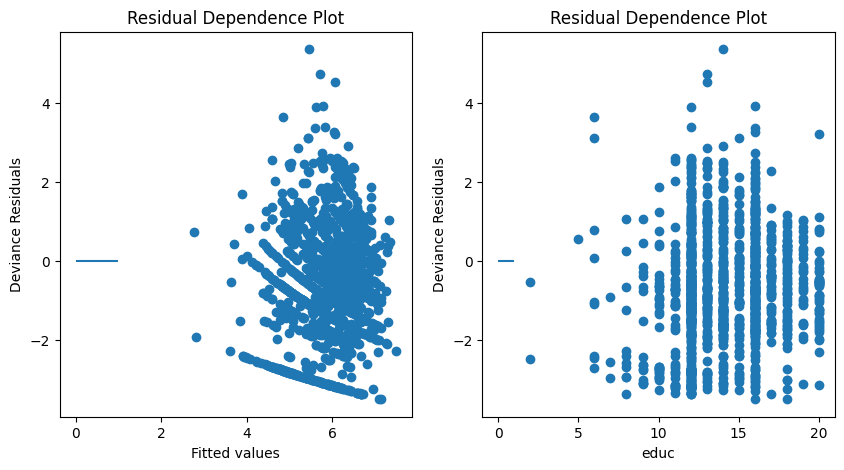

In [23]:
resid = fitted_glm.resid_deviance

fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(np.log(fitted_glm.mu), resid)
ax[0].hlines(0, 0, 1)
ax[0].set_title('Residual Dependence Plot')
ax[0].set_ylabel('Deviance Residuals')
ax[0].set_xlabel('Fitted values')

X_train = dat_train.drop(["emailmintotal"], axis=1)
ax[1].scatter(X_train['educ'], resid)
ax[1].hlines(0, 0, 1)
ax[1].set_title('Residual Dependence Plot')
ax[1].set_ylabel('Deviance Residuals')
ax[1].set_xlabel('educ')
plt.show()

Nhận thấy, giá trị phần dư chuẩn hóa theo biến educ và fitted values có phân phối tương đối cân bằng xung quanh trục y=0.

Ta tiếp tục kiểm tra phân phối chuẩn của phần dư bằng biểu đồ QQplot

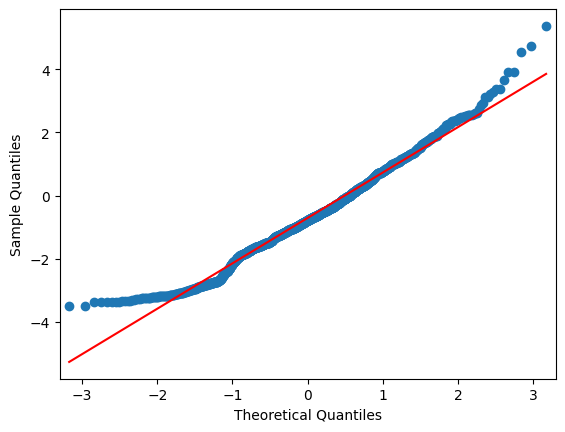

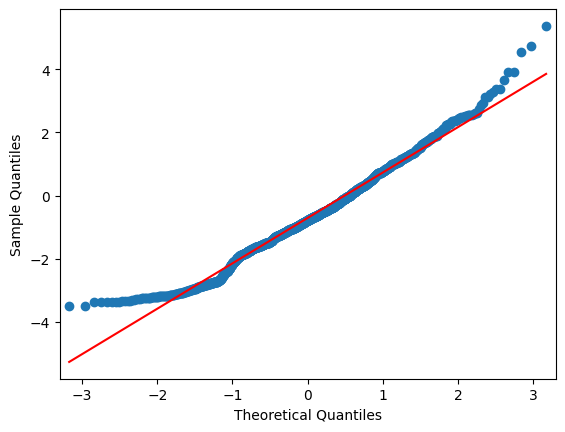

In [24]:
from statsmodels import graphics
graphics.gofplots.qqplot(resid, line='r')

Biểu đồ qqplot cho thấy phần dư chuẩn hóa khá khớp với phân phối chuẩn.

In [31]:
infl = fitted_glm.get_influence(observed=False)

summ_df = infl.summary_frame()

summ_df[["dfb_educ", "cooks_d", "standard_resid", "hat_diag", "dffits_internal"]].sort_values("cooks_d", ascending=False)[:20]

,dfb_educ,cooks_d,standard_resid,hat_diag,dffits_internal
2146,0.077382,0.084860,10.872702,0.016936,1.427110
2362,-0.026784,0.082191,8.168260,0.028716,1.404491
263,-0.141820,0.080798,8.811287,0.024368,1.392532
1583,0.260457,0.057029,6.383517,0.032496,1.169908
2354,0.044985,0.039389,4.779811,0.039733,0.972280
620,0.011158,0.029940,0.833563,0.508397,0.847681
2151,0.011158,0.029940,-0.833563,0.508397,-0.847681
377,0.089603,0.028454,2.087020,0.135535,0.826378
2288,-0.419827,0.026417,5.658468,0.019417,0.796241
431,-0.121679,0.021319,6.266495,0.012862,0.715304


In [35]:
gss16.iloc[951]

harass5               NaN
emailmin              0.0
emailhr              35.0
educ                 12.0
polviews              NaN
advfront         Disagree
snapchat              NaN
instagrm              NaN
wrkstat     Keeping house
Name: 951, dtype: object

# 3. Mô hình GAM

In [27]:
from statsmodels.gam.api import GLMGam, BSplines

x_spline = dat_train[["educ"]]
bs = BSplines(x_spline, df=[10], degree=[3])
alpha = np.array([10])

# + wrkstat:educ + polviews:advfront
gam_bs = GLMGam.from_formula(formula = formula[4], \
                             data=dat_train, smoother=bs, alpha=alpha, \
                             family=sm.families.Gamma(link=sm.families.links.Log()))

fitted_gam = gam_bs.fit()
print('AIC: ',fitted_gam.aic)
print('BIC: ',fitted_gam.bic)
fitted_gam.summary()

AIC:  17602.364707947432
BIC:  -5922.420651700517


c:\Users\dungl\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:1838: FutureWarning: The bic value is computed using the deviance formula. After 0.13 this will change to the log-likelihood based formula. This change has no impact on the relative rank of models compared using BIC. You can directly access the log-likelihood version using the `bic_llf` attribute. You can suppress this message by calling statsmodels.genmod.generalized_linear_model.SET_USE_BIC_LLF with True to get the LLF-based version now or False to retainthe deviance version.
  warnings.warn(


<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          emailmintotal   No. Observations:                 1318
Model:                         GLMGam   Df Residuals:                  1288.72
Model Family:                   Gamma   Df Model:                        28.28
Link Function:                    Log   Scale:                          2.4291
Method:                         PIRLS   Log-Likelihood:                -8771.9
Date:                Sun, 13 Aug 2023   Deviance:                       3335.6
Time:                        15:03:02   Pearson chi2:                 3.13e+03
No. Iterations:                    38   Pseudo R-squ. (CS):             0.1575
Covariance Type:            nonrobust                                         
====================================================================================================
                                       coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------
Intercept                            6.1772   3.66e+05   1.69e-05      1.000   -7.17e+05    7.17e+05
wrkstat[T.Other]                     1.2950      0.390      3.319      0.001       0.530       2.060
wrkstat[T.Retired]                   0.1611      0.181      0.892      0.373      -0.193       0.515
wrkstat[T.School]                    0.1473      0.301      0.489      0.625      -0.443       0.738
wrkstat[T.Temp not working]          0.7072      0.324      2.181      0.029       0.072       1.343
wrkstat[T.Unempl, laid off]          0.8600      0.258      3.333      0.001       0.354       1.366
wrkstat[T.Working fulltime]          1.2283      0.163      7.557      0.000       0.910       1.547
wrkstat[T.Working parttime]          0.7098      0.196      3.618      0.000       0.325       1.094
polviews[T.Extremely liberal]       -0.4468      0.236     -1.891      0.059      -0.910       0.016
polviews[T.Extrmly conservative]    -0.6523      0.259     -2.516      0.012      -1.160      -0.144
polviews[T.Liberal]                 -0.2082      0.168     -1.238      0.216      -0.538       0.121
polviews[T.Moderate]                -0.0090      0.135     -0.066      0.947      -0.273       0.256
polviews[T.Not give]                 0.5264      0.261      2.018      0.044       0.015       1.038
polviews[T.Slghtly conservative]    -0.3026      0.161     -1.880      0.060      -0.618       0.013
polviews[T.Slightly liberal]        -0.0937      0.175     -0.537      0.591      -0.436       0.249
advfront[T.Disagree]                 0.4775      0.162      2.946      0.003       0.160       0.795
advfront[T.Dont know]               -0.6112      0.507     -1.206      0.228      -1.604       0.382
advfront[T.Not give]                -2.7389      1.113     -2.462      0.014      -4.920      -0.558
advfront[T.Strongly agree]           0.1139      0.114      1.001      0.317      -0.109       0.337
advfront[T.Strongly disagree]        0.3859      0.571      0.676      0.499      -0.733       1.505
harass5[T.No]                        0.7670      0.422      1.818      0.069      -0.060       1.594
harass5[T.Not give]                 -1.9381      1.184     -1.637      0.102      -4.258       0.382
harass5[T.Yes]                       1.1236      0.473      2.377      0.017       0.197       2.050
educ                                 0.0739   1.83e+05   4.04e-07      1.000   -3.59e+05    3.59e+05
educ_s0                              0.5934    6.1e+05   9.73e-07      1.000    -1.2e+06     1.2e+06
educ_s1                             -2.0451   1.22e+06  -1.68e-06      1.000   -2.39e+06    2.39e+06
educ_s2                             -0.1548   1.89e+06  -8.18e-08      1.000   -3.71e+06    3.71e+06
educ_s3                              0.1646   2.01e+0

**Diagnostic**

# 4. So sánh kết quả 2 mô hình

Phần này ta sẽ dùng **Cross Validation** để cùng chia tập train/test theo các cách ngẫu nhiên khác nhau, ghi lại kết quả và so sánh trung bình các thông số đánh giá của 2 mô hình như RMSE, R2, thời gian thực thi.

In [46]:
# predict GLM

X_train_ = dat_train[["emailmintotal","wrkstat", "educ", "polviews", "advfront"]]
y_train_ = dat_train['emailmintotal']


In [65]:
from sklearn.base import BaseEstimator, RegressorMixin
import statsmodels.formula.api as smf
import statsmodels.api as sm
 
class My_GLM(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None

 
    def fit(self,data,dummy):
        self.model = self.sm_class(self.formula,data,family=sm.families.Gamma(link=sm.families.links.Log()))
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

class My_GAM(BaseEstimator, RegressorMixin):
    def __init__(self, sm_class, formula):
        self.sm_class = sm_class
        self.formula = formula
        self.model = None
        self.result = None
 
    def fit(self,data,dummy):
        if self.sm_class == smf.glm:
            self.model = self.sm_class(self.formula,data, family=sm.families.Gamma(link=sm.families.links.Log()))
        else:
            self.model = self.sm_class(self.formula,data, bs=self.bs, alpha=self.alpha, family=sm.families.Gamma(link=sm.families.links.Log()))
        self.result = self.model.fit()
 
    def predict(self,X):
        return self.result.predict(X)

In [66]:
clf = My_GAM(smf.glm, "emailmintotal ~ wrkstat + educ + polviews + advfront")
kfold = KFold(n_splits=5)
cv_results = cross_val_score(clf, X_train_, y_train_, cv=kfold)
msg = "%f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

0.046344 (0.025877)


# 5. Kết luận

Mô hình nào tốt hơn, vì sao

Vì sao R2 thấp, hướng phát triển tiếp theo